In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp

<Figure size 1500x1000 with 0 Axes>

In [3]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') and (row['PR Status'] == 'Negative') and (row['HER2 Status'] == 'Negative')) else False, axis = 1)
new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') and (row['PR Status'] == 'Negative') and (row['HER2 Status'] == 'Positive')) else False, axis = 1)

full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2, alternative='two-sided')
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [296]:
significant_pathways = {}
def failures_of_null_mann_u(cluster, my_xa, my_xb, iterations = 10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    z_scores = norm.ppf(pvalues)

    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')
    print(xa, xb)

    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    ax.legend(loc='best')
    plt.show()

    p_vals = norm.sf(abs(z_scores), par[2], par[3])

    #print(pvalues[:10])
    print('the 20 pathways with lowest p-val')
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {sig_pathways}')
    

Quantiles calculated: -3.6455980157566934, 1.6525592688523207
-3.6455980157566934 1.6525592688523207
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2174.406830783949
            Iterations: 256
            Function evaluations: 1997
            Gradient evaluations: 256
[-1.17069472  1.39465353 -1.22778798  2.065278  ]


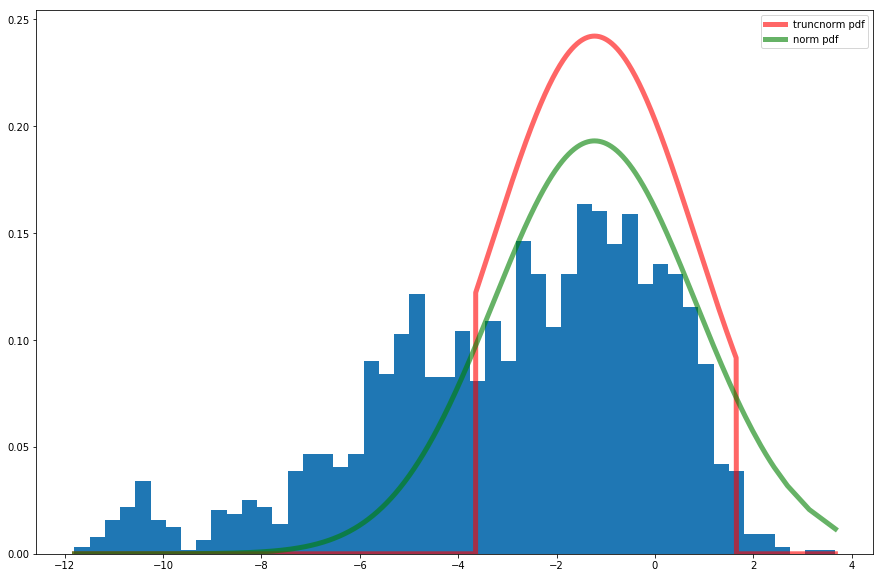

the 20 pathways with lowest p-val
[1.41595451e-10 2.90877332e-10 4.83664458e-10 5.19909084e-10
 5.19909084e-10 6.52787896e-10 7.31452380e-10 1.27697887e-09
 1.35726154e-09 1.75488260e-09 1.85421467e-09 2.00722086e-09
 2.01672767e-09 2.22380962e-09 2.22780551e-09 2.22780551e-09
 2.32687423e-09 2.52784560e-09 2.74444835e-09 3.05020113e-09]
number of pathways with p < 0.001: 427


In [301]:
failures_of_null_mann_u('1', 35, 99)

Quantiles calculated: -4.721411860906618, 3.677293009621752
-4.721411860906618 3.677293009621752
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3638.7567112101556
            Iterations: 5
            Function evaluations: 36
            Gradient evaluations: 5
[-2.48251476  3.2146488  -1.06171198  1.47419058]


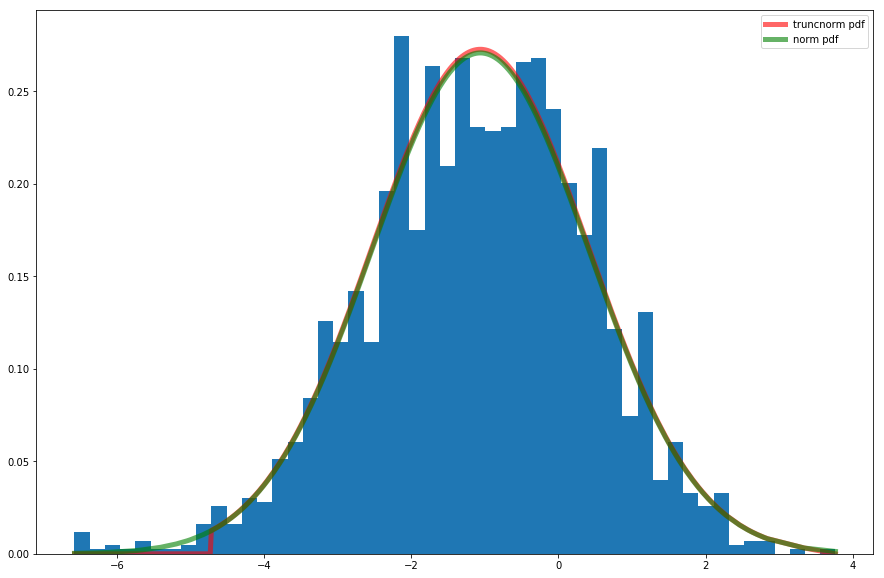

the 20 pathways with lowest p-val
[1.09738690e-07 1.58495496e-07 1.68181675e-07 1.69721746e-07
 1.89873192e-07 3.23104386e-07 5.23478321e-07 5.52520248e-07
 1.82732086e-06 1.95762635e-06 2.55616906e-06 2.55792684e-06
 5.75272663e-06 1.09892729e-05 1.70481127e-05 1.97333112e-05
 3.12700479e-05 3.12700479e-05 3.21458383e-05 4.19525130e-05]
number of pathways with p < 0.001: 115


In [302]:
failures_of_null_mann_u('2', 1, 99.99)

Quantiles calculated: -6.042957566903017, 1.6295895654912358
-6.042957566903017 1.6295895654912358
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3028.2593098911852
            Iterations: 116
            Function evaluations: 888
            Gradient evaluations: 116
[-1.62450193  1.6340254  -2.21789601  2.35460574]


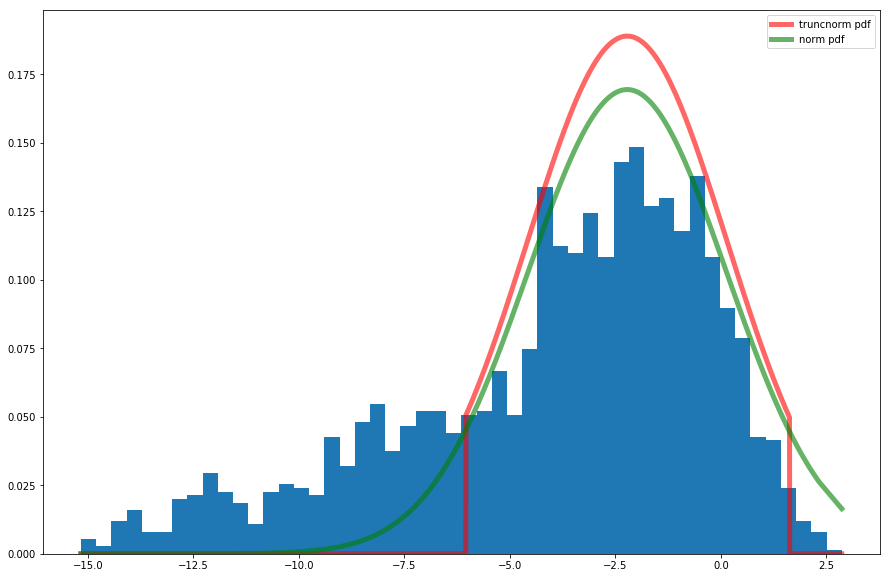

the 20 pathways with lowest p-val
[7.74282149e-14 1.17122481e-13 1.43260485e-13 2.17699594e-13
 5.12719696e-13 6.23830923e-13 9.41046131e-13 9.67804342e-13
 9.68131238e-13 1.01875614e-12 1.34112323e-12 1.35060836e-12
 1.41982333e-12 1.58839277e-12 2.13458864e-12 2.57417948e-12
 2.94342567e-12 3.07463396e-12 3.22112168e-12 3.22112168e-12]
number of pathways with p < 0.001: 635


In [303]:
failures_of_null_mann_u('3', 25, 99)

[1.0]
Quantiles calculated: -6.189468356137086, 1.3447442129891578
-6.189468356137086 1.3447442129891578
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2649.9500248584313
            Iterations: 60
            Function evaluations: 444
            Gradient evaluations: 60
[-1.0053594   1.32559223 -2.93989795  3.23224749]


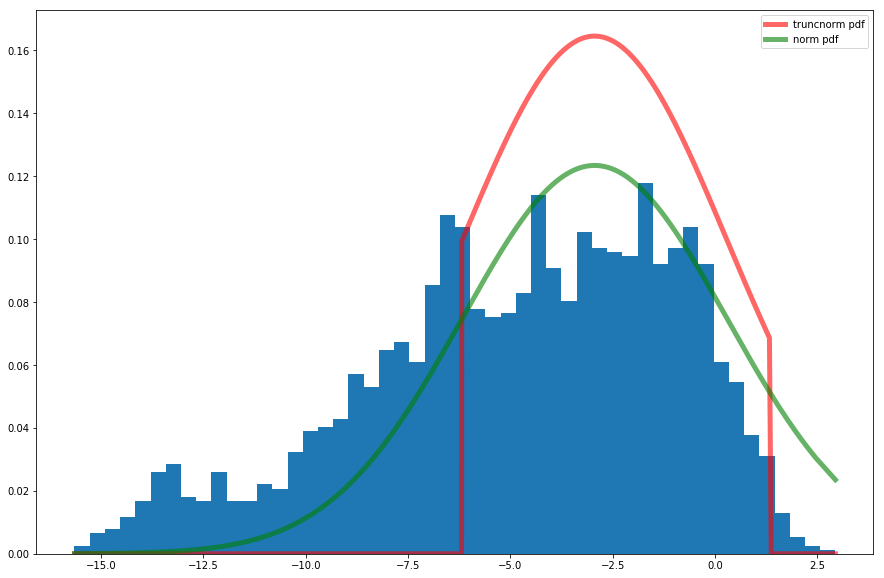

the 20 pathways with lowest p-val
[4.42684617e-09 4.47691404e-09 9.27233319e-09 1.05254972e-08
 1.21612475e-08 1.43663349e-08 1.54603009e-08 1.68607260e-08
 1.77650488e-08 1.92338155e-08 2.10110785e-08 2.48693566e-08
 2.65860478e-08 3.49186127e-08 3.63048580e-08 3.83431417e-08
 4.07667491e-08 4.71277782e-08 4.75869317e-08 4.89034577e-08]
number of pathways with p < 0.001: 552


In [304]:
print(clusterframes['4ER-']['p-values'].tolist()[-1:])

failures_of_null_mann_u('4ER+', 35, 99)

Quantiles calculated: -4.061822316645685, 0.19442570332194628
-4.061822316645685 0.19442570332194628
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1493.1838578389843
            Iterations: 206
            Function evaluations: 1553
            Gradient evaluations: 206
[-0.97660625  0.65064762 -1.50740933  2.61560171]


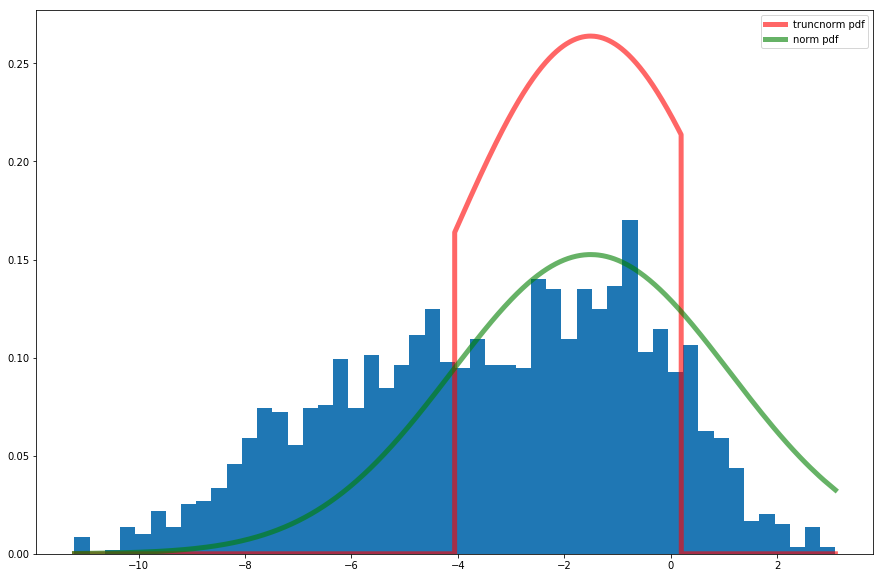

the 20 pathways with lowest p-val
[5.88943548e-07 7.06087115e-07 7.67718136e-07 8.98461648e-07
 9.36698226e-07 2.11192216e-06 2.99435495e-06 2.99648015e-06
 3.32510221e-06 3.88892938e-06 3.96883026e-06 4.41705409e-06
 4.45107969e-06 4.49631488e-06 4.99426744e-06 5.52937726e-06
 5.65096529e-06 6.87814071e-06 6.99913134e-06 7.73193737e-06]
number of pathways with p < 0.001: 324


In [305]:
failures_of_null_mann_u('4ER-', 40, 90)

Quantiles calculated: -5.396974064338168, 0.7882155497637023
-5.396974064338168 0.7882155497637023
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2793.459881961139
            Iterations: 274
            Function evaluations: 2157
            Gradient evaluations: 274
[-1.38010463  0.87770187 -1.61622101  2.73946843]


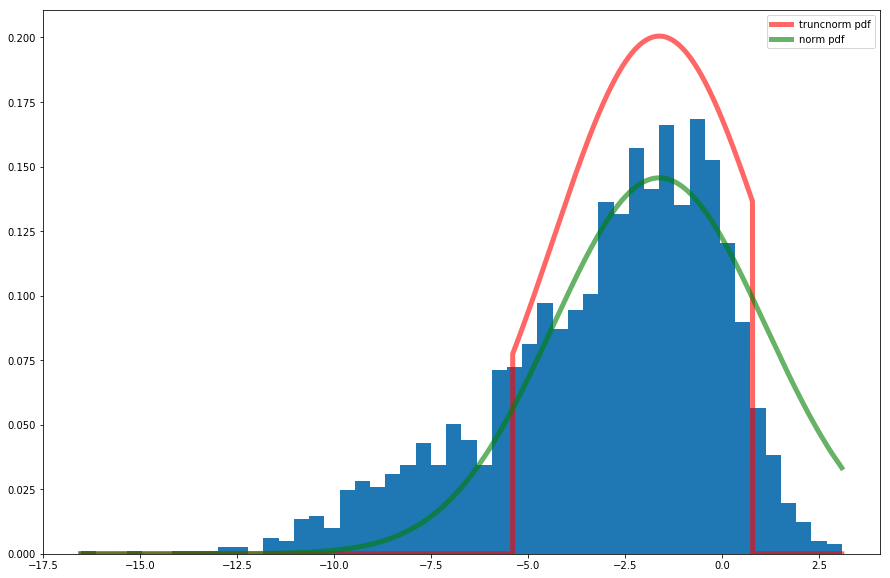

the 20 pathways with lowest p-val
[1.75762964e-11 3.44224729e-10 4.83610466e-09 2.12885807e-08
 2.44217595e-08 5.92416051e-08 6.88067037e-08 1.09488956e-07
 1.49891240e-07 5.61130945e-07 5.73836018e-07 6.15594541e-07
 7.80695693e-07 9.38500689e-07 1.10639025e-06 1.24818815e-06
 1.70672524e-06 1.70672524e-06 1.96891474e-06 1.99071697e-06]
number of pathways with p < 0.001: 257


In [315]:
failures_of_null_mann_u('5', 20, 95, iterations=100000)

Quantiles calculated: -5.55552100309645, 2.0050858038979795
-5.55552100309645 2.0050858038979795
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3837.8467901600497
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
[-2.17922981  1.84014988 -1.45630645  1.88103821]


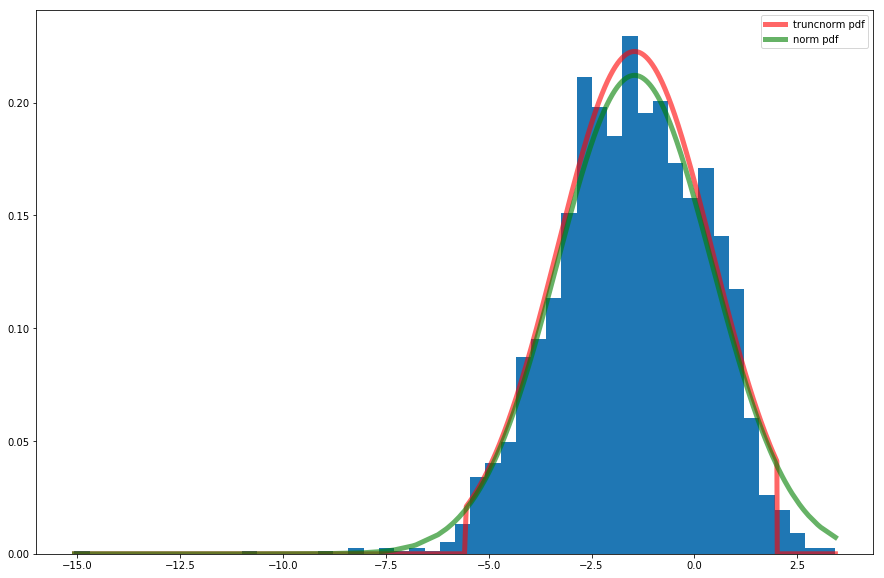

the 20 pathways with lowest p-val
[7.98335401e-19 5.83011266e-11 2.13373587e-08 2.02717057e-07
 2.22787116e-07 6.61761487e-07 1.08727340e-06 1.67808209e-06
 5.07695319e-06 6.17914084e-06 2.18225192e-05 3.40281384e-05
 3.73701624e-05 4.84369132e-05 5.37668041e-05 6.38749001e-05
 6.57715842e-05 6.68953553e-05 6.87021601e-05 8.24256089e-05]
number of pathways with p < 0.001: 118


In [307]:
failures_of_null_mann_u('6', 1, 99)

Quantiles calculated: -10.689419822374397, 1.6306705597899587
-10.689419822374397 1.6306705597899587
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4828.76444626053
            Iterations: 39
            Function evaluations: 280
            Gradient evaluations: 39
[-2.28542311  1.48982984 -3.23121248  3.26338143]


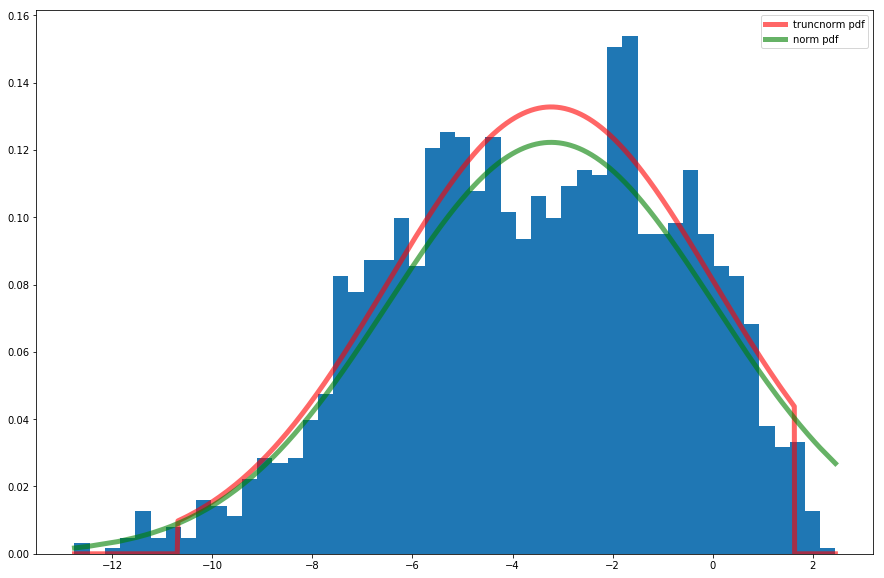

the 20 pathways with lowest p-val
[4.84641315e-07 7.42146549e-07 1.81069235e-06 2.97902209e-06
 2.97902209e-06 2.97959779e-06 3.09869579e-06 3.18224717e-06
 3.42032367e-06 3.63304633e-06 4.16199582e-06 4.38138759e-06
 4.42657350e-06 4.44511003e-06 4.96613898e-06 6.08398579e-06
 6.82981594e-06 7.37240798e-06 7.42184555e-06 8.31533911e-06]
number of pathways with p < 0.001: 304


In [308]:
failures_of_null_mann_u('7', 1, 99)

Quantiles calculated: -11.774442304156626, 2.3707578256122517
-11.774442304156626 2.3707578256122517
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4838.433456137054
            Iterations: 8
            Function evaluations: 52
            Gradient evaluations: 8
[-1.59520355  1.53044396 -4.55530662  4.52552634]


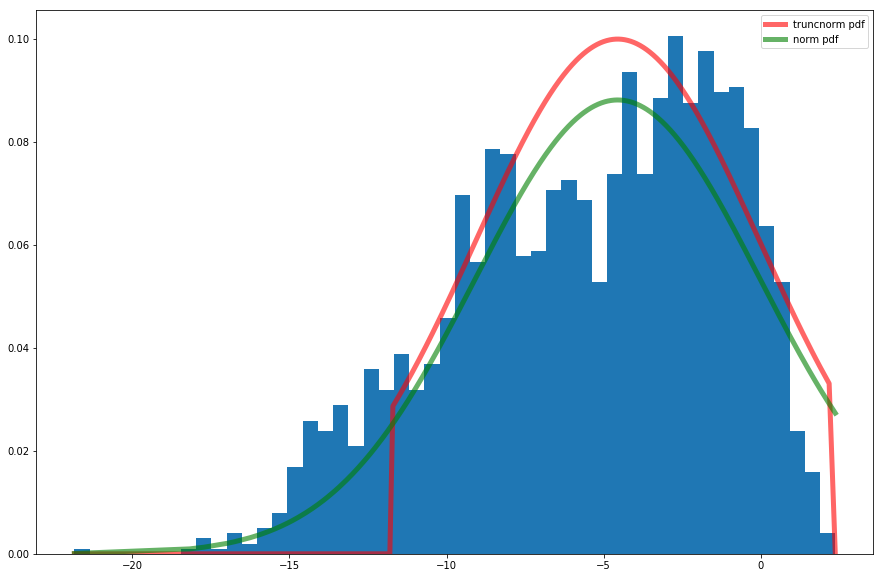

the 20 pathways with lowest p-val
[2.72104718e-09 2.55884540e-07 3.58610362e-07 3.59994168e-07
 4.28566907e-07 9.43896435e-07 9.68628671e-07 9.70136878e-07
 1.09212625e-06 1.27746950e-06 2.14502150e-06 2.39191321e-06
 2.78026277e-06 3.24369899e-06 3.25146702e-06 3.25813951e-06
 3.97108668e-06 4.56108022e-06 4.83779604e-06 5.30719757e-06]
number of pathways with p < 0.001: 405


In [309]:
failures_of_null_mann_u('8', 10, 99.999999)

Quantiles calculated: -5.14815512408712, 3.123213783661022
-5.14815512408712 3.123213783661022
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3458.1217976205285
            Iterations: 109
            Function evaluations: 857
            Gradient evaluations: 109
[-1.51648703  2.37596384 -1.92565494  2.12497709]


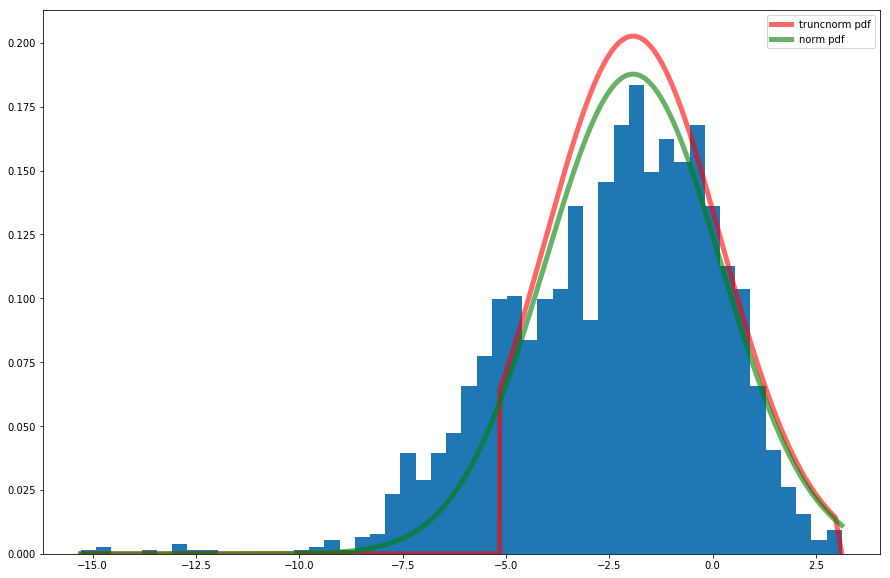

the 20 pathways with lowest p-val
[2.80391506e-16 1.98887055e-15 1.99111123e-15 1.96269492e-13
 1.02874155e-12 1.92661263e-12 2.08698694e-12 6.39356734e-12
 1.31842314e-11 1.64831177e-08 2.80902513e-08 4.97033756e-08
 6.94725953e-08 7.20377994e-08 1.05588060e-07 1.20649504e-07
 2.29768812e-07 4.50480638e-07 5.54521509e-07 5.80602884e-07]
number of pathways with p < 0.001: 415


In [310]:
failures_of_null_mann_u('9', 15, 99.999999)

Quantiles calculated: -8.246926240978127, -0.7254176748169232
-8.246926240978127 -0.7254176748169232
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1674.788378210421
            Iterations: 934
            Function evaluations: 10374
            Gradient evaluations: 934
[-0.7125742   0.47882069 -3.7483062   6.31319526]


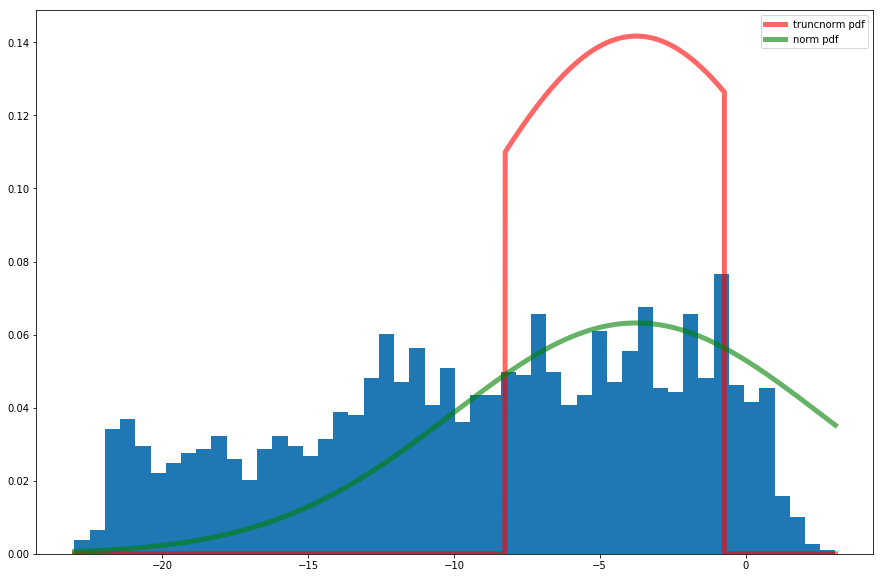

the 20 pathways with lowest p-val
[1.12196899e-05 1.34052152e-05 1.51361884e-05 1.51361884e-05
 1.69726308e-05 1.83414453e-05 2.03805260e-05 2.04510350e-05
 2.24672493e-05 2.30641137e-05 2.30757008e-05 2.46731378e-05
 2.50587967e-05 2.55584848e-05 2.56266726e-05 2.58258236e-05
 2.58408727e-05 2.60394347e-05 2.66040145e-05 2.68036762e-05]
number of pathways with p < 0.001: 378


In [328]:
failures_of_null_mann_u('10', 50, 90, iterations = 100000)

In [329]:
significant_pathways

{'2': 115,
 '4ER-': 324,
 '5': 257,
 '1': 427,
 '3': 635,
 '4ER+': 552,
 '6': 118,
 '7': 304,
 '8': 405,
 '9': 415,
 '10': 378}

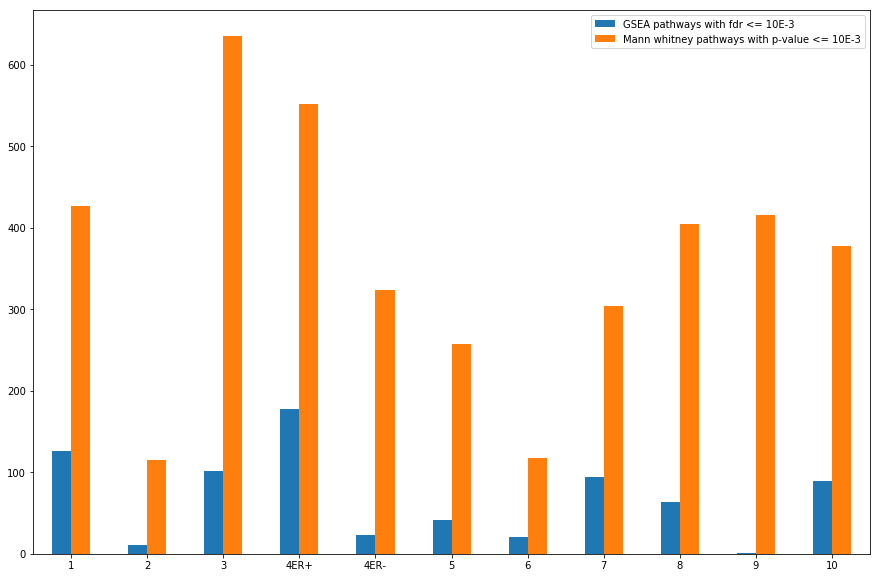

In [330]:
gsea_df = pd.read_csv('../exp/GSEA_qvalues.csv', index_col = 0)
gsea_df_counts = {}

for column in gsea_df.columns:
    columnshape = gsea_df[gsea_df[column] >= 3].shape[0]
    gsea_df_counts[column] = columnshape
    
full_df = pd.DataFrame({'GSEA pathways with fdr <= 10E-3': gsea_df_counts, 
                       'Mann whitney pathways with p-value <= 10E-3': significant_pathways})
ax = full_df.plot.bar(rot=0, figsize=(15, 10))
ax